# The factory dataset

![chocolate factory](factory_1.jpeg)

### Type of failures

Survival analysis can be used for predictive maintenance in industrial settings. In this work, we will create a synthetic dataset of machines and operators with their associated simulated failures, in a competitive events setting. Our factory failures can be of three types:

**1. Initial assembly failures $e_1$**

This failure might occure during the first weeks after the machine setup. As these hazards could be due to some incorrect wiring or components assembly, they are dependent on the quality of assembly of each machine, along with its usage rate.

**2. Operation failure $e_2$**

Operation failures can occur on a day to day basis because of some critical mistakes made by the operator. The probability of making mistakes is linked to the ease of use (UX) of the machine, the expertise of the operator and the usage rate of the machine.

**3. Fatigue failure $e_3$**

Fatigue failure relate the wear of the material and component of each machine through time. This type of hazard is linked to the quality of the material of the machine and also its usage rate.

### Observed and hidden variables
We will make the simplistic assumptions that the variables of interest are constant through time. To create non-linearities and make the dataset more challenging, we consider that the observer don't have access to the three machine characteristics: assembly quality, UX and material quality.

Instead, the observer has only access to the **brand** of the machine and its **model**. They also know the **usage rate** because it is linked to the production planning, and they have access to the **training level** of each operators.

<img src="variables.png" width="60%">

So, in summary:

|failure id |failure name |associated features         |
|-----------|-------------|----------------------------|
|$e_1$      |assembly     |assembly quality, usage rate|
|$e_2$      |operation    |UX, operator training, usage rate|
|$e_3$      |fatigue      |material quality, usage rate|

## Operators and machines properties

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

rng = np.random.RandomState(42)

We consider 10,000 pairs (operator, machine) with constant features. The period span on 2 years.

In [5]:
N = 10_000
total_period = 2 * 365

### Operator training

Across the factory, 1/3 of operators have little to no experience, another 1/3 have prior hands-on training and the last 1/3 has had a formal training on all equipments. We distinguish their skills as:

In [6]:
op_skills = [.5, .8, 1]

df = pd.DataFrame(
    dict(
        operator_skills=rng.choice(op_skills, size=N)
    )
)
df.head()

,operator_skills
0,1.0
1,0.5
2,1.0
3,1.0
4,0.5


### Assembly quality

Let's imagine that the assembly quality depends on the supplier brand. There are two brands on the market, B1 and B2. B2 is cheaper but has an assembly quality that is less reliable:

$Q(B_1) \sim \mathcal{N}(0.90, 0.025) \\ Q(B_2) \sim \mathcal{N}(0.85, 0.050)$

In [7]:
from scipy.stats import norm

def get_norm_x_y(mu, sigma):
    x = np.linspace(
        norm.ppf(0.01, loc=mu, scale=sigma),
        norm.ppf(0.99, loc=mu, scale=sigma),
    )
    y = norm.pdf(x, loc=mu, scale=sigma)
    return x, y

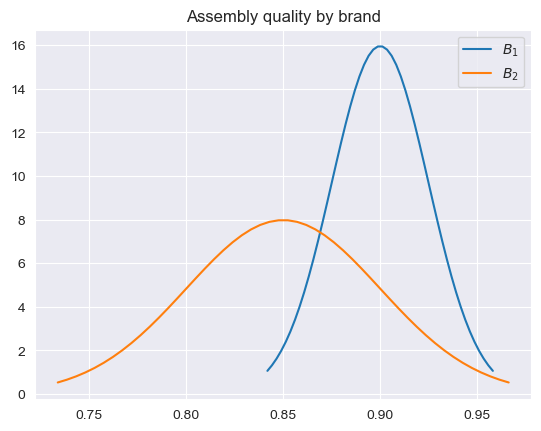

In [8]:
q_mu_1, q_sigma_1 = .90, 0.025
q_mu_2, q_sigma_2 = .85, 0.050

x_1, y_1 = get_norm_x_y(q_mu_1, q_sigma_1)
x_2, y_2 = get_norm_x_y(q_mu_2, q_sigma_2)

fig, ax = plt.subplots()
ax.plot(x_1, y_1, label="$B_1$")
ax.plot(x_2, y_2, label="$B_2$")
ax.set_title("Assembly quality by brand")
plt.legend();

In [9]:
df["brand"] = pd.Series(["B1"] * (N//2) + ["B2"] * (N//2))

assembly_quality = np.hstack([
    norm.rvs(loc=q_mu_1, scale=q_sigma_1, size=N//2, random_state=rng),
    norm.rvs(loc=q_mu_2, scale=q_sigma_2, size=N//2, random_state=rng),
])
df["assembly_quality"] = assembly_quality

df.head()

,operator_skills,brand,assembly_quality
0,1.0,B1,0.893010
1,0.5,B1,0.865941
2,1.0,B1,0.862826
3,1.0,B1,0.852275
4,0.5,B1,0.915824


### UX

Both brands produce 5 models with similar UX, depending on the year there were designed. Older machines are often less intuitive and trickier to use, so we imagine a UX that is increasing for each new machine generation.

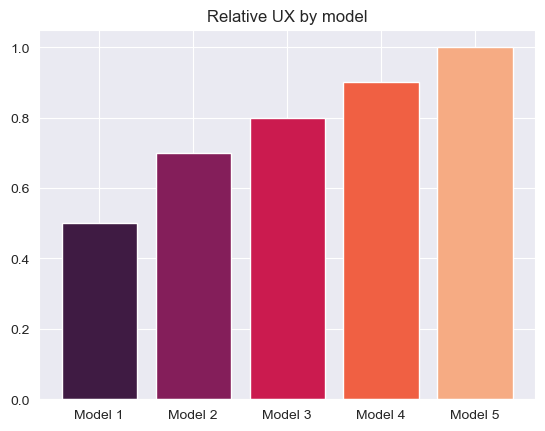

In [10]:
ux_levels = [.5, .7, .8, .9, 1]
labels = [f"Model {idx}" for idx in range(1, len(ux_levels)+1)]
ux_models = dict(zip(ux_levels, labels))

fig, ax = plt.subplots()
palette = sns.color_palette("rocket", n_colors=5)
plt.bar(labels, height=ux_levels, color=palette);
plt.title("Relative UX by model");

In [11]:
ux = rng.choice(ux_levels, size=N)
df["model_id"] = pd.Series(ux).map(ux_models)
df["ux"] = ux

df.head()

,operator_skills,brand,assembly_quality,model_id,ux
0,1.0,B1,0.893010,Model 5,1.0
1,0.5,B1,0.865941,Model 5,1.0
2,1.0,B1,0.862826,Model 1,0.5
3,1.0,B1,0.852275,Model 1,0.5
4,0.5,B1,0.915824,Model 4,0.9


### Material quality

Both brands also use similar alloys and plastics, however newer machines are often built with cheaper components, so that the more recent the model, the lower the overall material quality. 

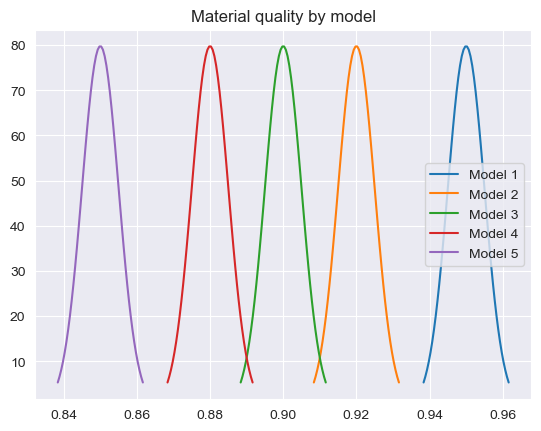

In [12]:
fig, ax = plt.subplots()

material_quality = [
    (.95, .005),
    (.92, .005),
    (.90, .005),
    (.88, .005),
    (.85, .005),
]
material_models = dict(zip(labels, material_quality))

for idx, (mu, sigma) in enumerate(material_quality, 1):
    x, y = get_norm_x_y(mu, sigma)
    ax.plot(x, y, label=f"Model {idx}")
    ax.set_title("Material quality by model")
    plt.legend();

In [13]:
materials_stats = df["model_id"].map(material_models)
df["materials"] = np.hstack([
    norm.rvs(loc=m_mu, scale=m_sigma, random_state=rng, size=1)
    for m_mu, m_sigma in materials_stats
])
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials
0,1.0,B1,0.893010,Model 5,1.0,0.841782
1,0.5,B1,0.865941,Model 5,1.0,0.849880
2,1.0,B1,0.862826,Model 1,0.5,0.951406
3,1.0,B1,0.852275,Model 1,0.5,0.945052
4,0.5,B1,0.915824,Model 4,0.9,0.887111


### Usage rate

Finally, depending on their position in the production line but independently to their model, each machine has a specific usage rate, that will linearly impact each of the 3 hazards. We can imagine a bimodal distribution of the usage, with some machines being used almost continuously while some others are used in batches.

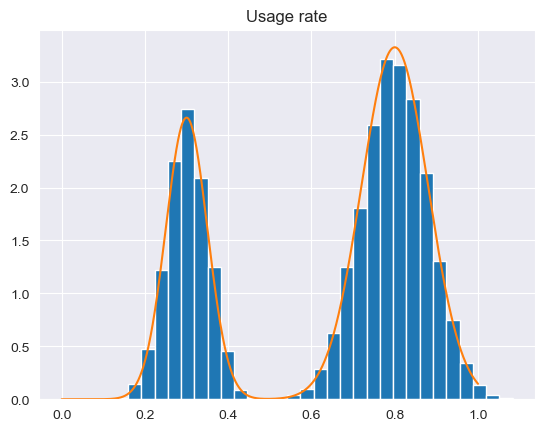

In [14]:
u_mu_1, u_sigma_1 = .3, .05
u_mu_2, u_sigma_2 = .8, .08
usage_params = [(u_mu_1, u_sigma_1 ), (u_mu_2, u_sigma_2)]

usage_weights = np.array([.5, 1])
usage_weights /= usage_weights.sum()
usage_mixture_idxs = rng.choice(len(usage_weights), size=N, p=usage_weights)

y = np.hstack([
    norm.rvs(*usage_params[idx], random_state=rng)
    for idx in usage_mixture_idxs
])

fig, ax = plt.subplots()
ax.hist(y, density=True, bins=30)

x = np.linspace(0, 1, N)
y_pdf = np.zeros(x.shape[0])
for (u_mu, u_sigma), w in zip(usage_params, usage_weights):
    y_pdf += norm.pdf(x, loc=u_mu, scale=u_sigma) * w

ax.plot(x, y_pdf)
ax.set_title("Usage rate");

In [15]:
df["usage_rate"] = y
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate
0,1.0,B1,0.893010,Model 5,1.0,0.841782,0.824038
1,0.5,B1,0.865941,Model 5,1.0,0.849880,0.867346
2,1.0,B1,0.862826,Model 1,0.5,0.951406,0.333465
3,1.0,B1,0.852275,Model 1,0.5,0.945052,0.899189
4,0.5,B1,0.915824,Model 4,0.9,0.887111,0.843027


## Assembly failure $e_1$

We model the h1 hazard with the [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution):

$f(x, \lambda, k)=\begin{cases}\frac{k}{\lambda}(\frac{x}{\lambda})^{k-1}e^{-(x/\lambda)^k} & \mathrm{if}\; x \geq 0 \\ 0 & \mathrm{o.w.}\end{cases}$

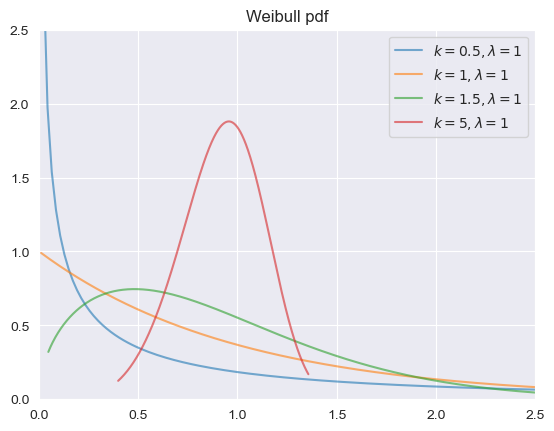

In [16]:
from scipy.stats import weibull_min

fig, ax = plt.subplots()
for k in [.5, 1, 1.5, 5]:
    x = np.linspace(
        weibull_min.ppf(0.01, k),
        weibull_min.ppf(0.99, k),
        1000,
    )
    y = weibull_min.pdf(x, k, loc=0, scale=1)
    ax.plot(x, y, alpha=0.6, label=f"$k={k}, \lambda=1$");
ax.set(
    title="Weibull pdf",
    xlim=[0, 2.5],
    ylim=[0, 2.5],
);
plt.legend();

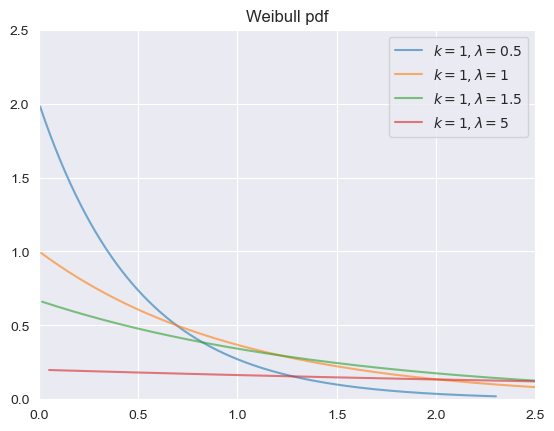

In [17]:
from scipy.stats import weibull_min

k = 1
fig, ax = plt.subplots()
for l in [.5, 1, 1.5, 5]:
    t = np.linspace(
        weibull_min.ppf(0.01, k, scale=l),
        weibull_min.ppf(0.99, k, scale=l),
        1000,
    )
    y = weibull_min.pdf(t, k, loc=0, scale=l)
    ax.plot(t, y, alpha=0.6, label=f"$k={k}, \lambda={l}$");
ax.set(
    title="Weibull pdf",
    xlim=[0, 2.5],
    ylim=[0, 2.5],
);
plt.legend();

So we want a fix shape parameter $k$ and a scale $\lambda$ that varies according to our couple (machine, operator).

Therefore, $\lambda \propto \mathrm{assembly\; quality} \times (1 - \mathrm{usage\; rate})$

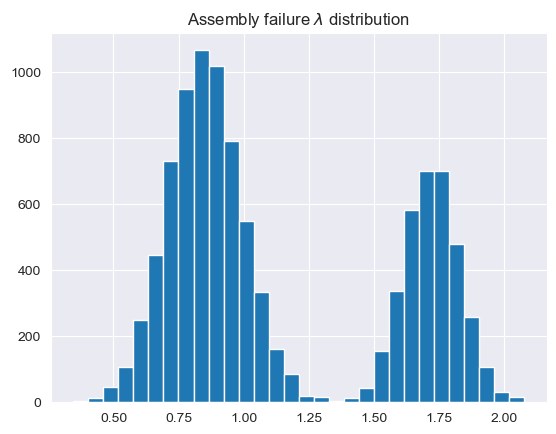

In [18]:
df["e_1_lambda"] = 2 * df["assembly_quality"] * (1-df["usage_rate"]) + .5
plt.hist(df["e_1_lambda"], bins=30);
plt.title("Assembly failure $\lambda$ distribution");

In [19]:
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_lambda
0,1.0,B1,0.893010,Model 5,1.0,0.841782,0.824038,0.814272
1,0.5,B1,0.865941,Model 5,1.0,0.849880,0.867346,0.729741
2,1.0,B1,0.862826,Model 1,0.5,0.951406,0.333465,1.650207
3,1.0,B1,0.852275,Model 1,0.5,0.945052,0.899189,0.671838
4,0.5,B1,0.915824,Model 4,0.9,0.887111,0.843027,0.787519


Let's convert the x axis from weeks to days, and scale the y by 100.

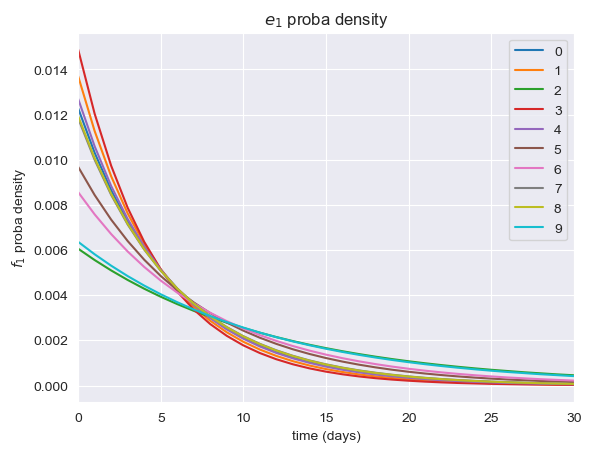

In [20]:
total_weeks = total_period // 7
t = np.linspace(0, total_weeks, total_period)
e_1 = np.vstack([
    weibull_min.pdf(t, 1, loc=0, scale=l) / 100
    for l in df["e_1_lambda"].values
])

fig, ax = plt.subplots()
for idx, e_1_ in enumerate(e_1[:10]):
    ax.plot(t * 7, e_1_, label=idx)  # from weeks to days
ax.set(
    title="$e_1$ proba density",
    xlabel="time (days)",
    ylabel="$f_1$ proba density",
    xlim=(0, 30),
)
plt.legend();

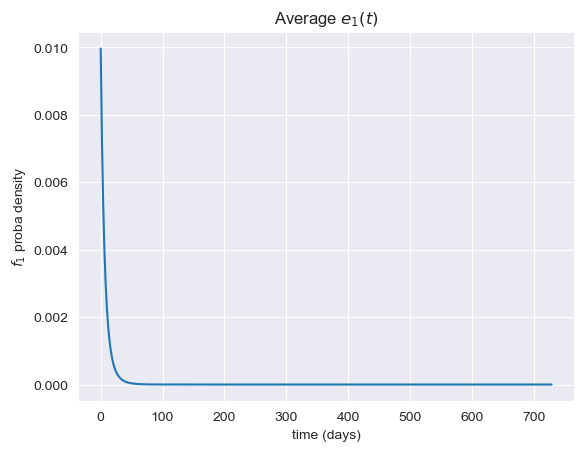

In [21]:
fig, ax = plt.subplots()
ax.plot(e_1.mean(axis=0))
ax.set(
    title="Average $e_1(t)$",
    xlabel="time (days)",
    ylabel="$f_1$ proba density",
);

## Operation failure $e_2$

We consider the operation hazard to be constant.

Therefore $e_2 \propto (\frac{1}{\mathrm{operator\; training}})\times \frac{1}{\mathrm{UX}} \times \mathrm{usage\; rate}$.

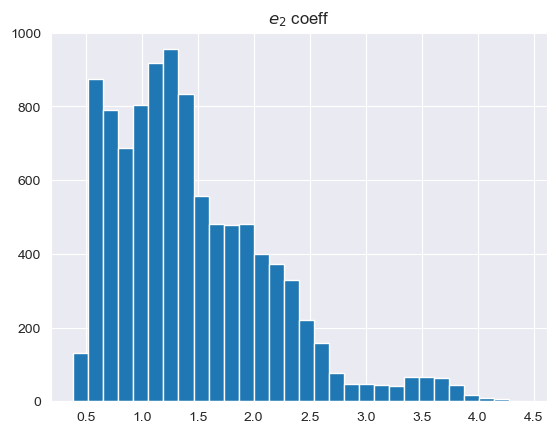

In [22]:
df["e_2_coeff"] = 1/df["operator_skills"] * 1/df["ux"] * df["usage_rate"] + .25
plt.hist(df["e_2_coeff"], bins=30);
plt.title("$e_2$ coeff");

The baseline is one failure every 3 years, which we multiply be the $e_2$ coeff.

In [23]:
e_2_base = 1 / (365 * 3)
e_2_base

0.0009132420091324201

In [24]:
e_2_coeff = e_2_base * df["e_2_coeff"]
e_2 = np.vstack([
    np.full_like(t, e_2_coeff_)
    for e_2_coeff_ in e_2_coeff
])

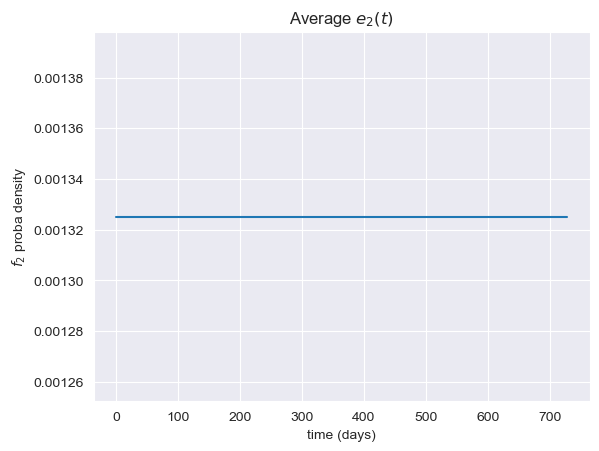

In [25]:
fig, ax = plt.subplots()
ax.plot(7*t, e_2.mean(axis=0))
ax.set(
    title="Average $e_2(t)$",
    xlabel="time (days)",
    ylabel="$f_2$ proba density",
);

## Fatigue failure $e_3$

Lastly, usage failure start to increase from some $t > t_{fatigue}$, and then plateau at a high probability regime, in a logistic way.

Here, $e_3 \propto (1-\mathrm{materials}) \times \mathrm{usage\; rate}$

In [26]:
def logistic(x, w, offset):
    return 1 / (1 + np.exp((-x + offset) * w))

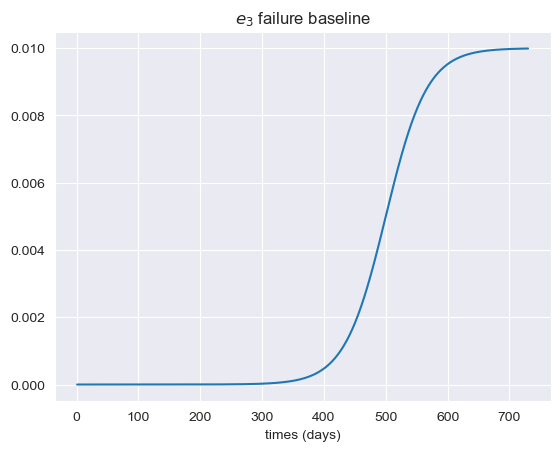

In [27]:
t = np.arange(1, total_period+1)
y = logistic(t, w=.03, offset=500) / 100
plt.plot(t, y);
plt.title("$e_3$ failure baseline")
plt.xlabel("times (days)");

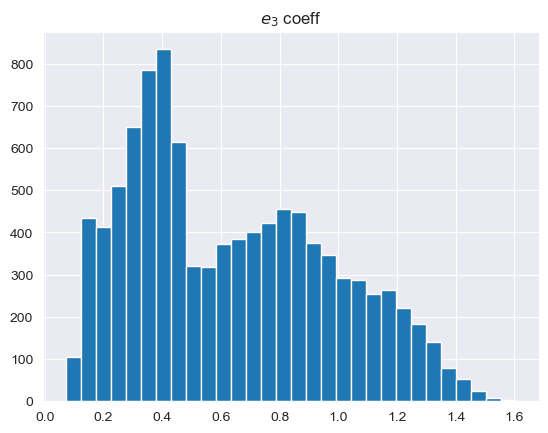

In [28]:
df["e_3_coeff"] = 10 * df["usage_rate"] * (1 - df["materials"])
plt.hist(df["e_3_coeff"], bins=30);
plt.title("$e_3$ coeff");

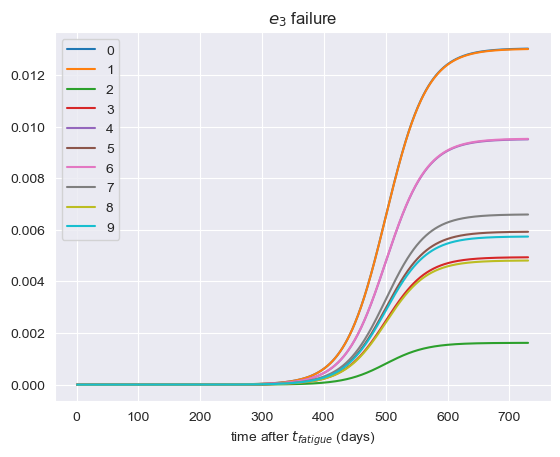

In [29]:
e_3 = np.vstack([
    y * e_3_coeff
    for e_3_coeff in df["e_3_coeff"]
])

fig, ax = plt.subplots()
for idx, e_3_ in enumerate(e_3[:10]):
    ax.plot(t, e_3_, label=idx)
ax.set(title="$e_3$ failure", xlabel="time after $t_{fatigue}$ (days)")
plt.legend();

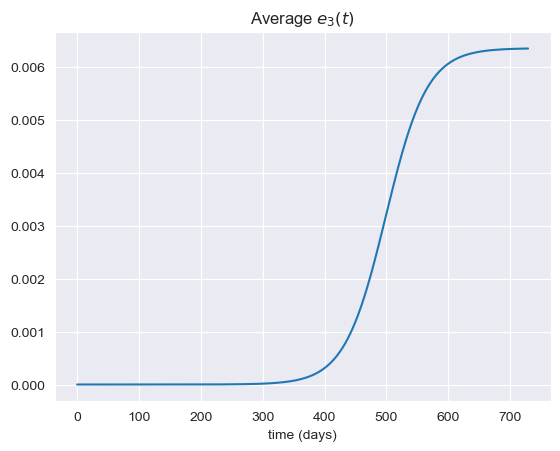

In [30]:
fig, ax = plt.subplots()
ax.plot(e_3.mean(axis=0))
ax.set(
    title="Average $e_3(t)$",
    xlabel="time (days)"
);

In [31]:
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_lambda,e_2_coeff,e_3_coeff
0,1.0,B1,0.893010,Model 5,1.0,0.841782,0.824038,0.814272,1.074038,1.303778
1,0.5,B1,0.865941,Model 5,1.0,0.849880,0.867346,0.729741,1.984692,1.302062
2,1.0,B1,0.862826,Model 1,0.5,0.951406,0.333465,1.650207,0.916931,0.162045
3,1.0,B1,0.852275,Model 1,0.5,0.945052,0.899189,0.671838,2.048378,0.494085
4,0.5,B1,0.915824,Model 4,0.9,0.887111,0.843027,0.787519,2.123394,0.951688


## Additive hazard curve (any event curve)

Let's enhance our understanding of these hazards by plotting the additive (any event) hazards for some couple (operator, machine).

In [32]:
e_1.shape, e_2.shape, e_3.shape

((10000, 730), (10000, 730), (10000, 730))

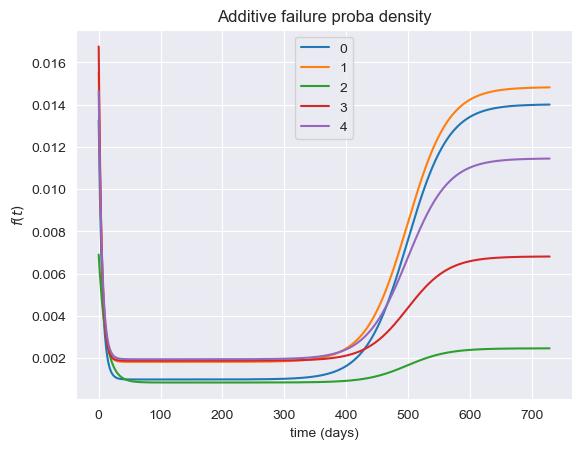

In [33]:
all_e = (e_1[:5] + e_2[:5] + e_3[:5])
fig, ax = plt.subplots()
for idx, e_ in enumerate(all_e):
    ax.plot(e_, label=idx)
ax.set(
    title="Additive failure proba density",
    xlabel="time (days)",
    ylabel="$f(t)$"
)
plt.legend();

In [34]:
df.head()

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_lambda,e_2_coeff,e_3_coeff
0,1.0,B1,0.893010,Model 5,1.0,0.841782,0.824038,0.814272,1.074038,1.303778
1,0.5,B1,0.865941,Model 5,1.0,0.849880,0.867346,0.729741,1.984692,1.302062
2,1.0,B1,0.862826,Model 1,0.5,0.951406,0.333465,1.650207,0.916931,0.162045
3,1.0,B1,0.852275,Model 1,0.5,0.945052,0.899189,0.671838,2.048378,0.494085
4,0.5,B1,0.915824,Model 4,0.9,0.887111,0.843027,0.787519,2.123394,0.951688


## Sampling from all hazards

Now that we have the event probability density for the entire period of observation, we can sample the failure for all (operator, machine) couples and define our target.

Our target `y` is comprised of two columns:
- `event`: 1, 2, 3 or 0 if no event occured during the period or if the observation was censored
- `duration`: the day when the event or censor was observed

In [35]:
from scipy.stats import bernoulli

def get_event_duration(event_matrix):
    trials = bernoulli.rvs(event_matrix, random_state=rng)
    event = np.any(trials, axis=1)
    duration = np.full(event.shape[0], fill_value=total_period)
    rows, cols = np.where(trials == 1)
    # Some trials might have more than one event,
    # we only keep the first one.
    # ex: trials = [[0, 0, 1, 0, 1]] -> duration = 2
    _, idxs = np.unique(rows, return_index=True)
    duration[event] = cols[idxs]
    return event, duration

In [36]:
event_1, duration_1 = get_event_duration(e_1)
print(f"total events: {event_1.sum()}, mean duration: {duration_1[event_1].mean():.2f}")

total events: 732, mean duration: 7.52


In [37]:
event_2, duration_2 = get_event_duration(e_2)
print(f"total events: {event_2.sum()}, mean duration: {duration_2[event_2].mean():.2f}")

total events: 5925, mean duration: 297.33


In [38]:
event_3, duration_3 = get_event_duration(e_3)
print(f"total events: {event_3.sum()}, mean duration: {duration_3[event_3].mean():.2f}")

total events: 7052, mean duration: 569.38


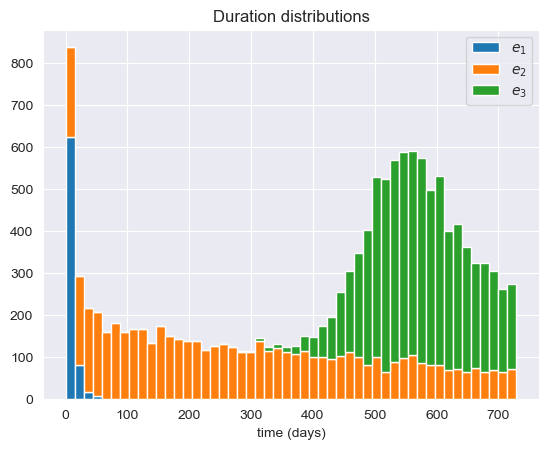

In [168]:
fig, ax = plt.subplots()
hists = [
    duration_1[event_1],
    duration_2[event_2],
    duration_3[event_3],
]
labels = [f"$e_{idx}$" for idx in range(1, 4)]
ax.hist(hists, bins=50, stacked=True, label=labels)
ax.set(
    title="Duration distributions",
    xlabel="time (days)",
)
plt.legend();

We can now build our any event target, which is an `OR` operation on all events.

In [45]:
any_event = np.logical_or(
    np.logical_or(
        event_1,
        event_2,
    ),
    event_3,
)
np.unique(any_event, return_counts=True)

(array([False,  True]), array([1222, 8778]))

For each couple (operator, machine), we only consider the first event that happened, if any. Indeed, if a machine failed from $e_2$, it won't fail for $e_3$.

In [46]:
stacked_durations = np.vstack([duration_1, duration_2, duration_3])
stacked_durations

array([[730, 730, 730, ..., 730, 730, 730],
       [ 45, 357, 118, ..., 527, 220, 730],
       [579, 663, 730, ..., 603, 625, 730]])

In [47]:
def get_first_event_duration(any_event, stacked_durations):
    duration_event = stacked_durations[:, any_event]
    first_hit = np.nanargmin(duration_event, axis=0)
    
    n_total = any_event.shape[0]
    n_events = duration_event.shape[1]

    duration = np.full(n_total, fill_value=total_period)
    jdxs = np.arange(n_events)

    duration[any_event] = duration_event[first_hit, jdxs]
    
    event = any_event.astype(int)
    event[np.where(event)] = first_hit + 1

    return event, duration

In [ ]:
df["event"], df["duration"] = get_first_event_duration(any_event, stacked_durations)

In [65]:
observed_variables_and_target = [
    "operator_skills",
    "brand",
    "model_id",
    "usage_rate",
    "duration",
    "event",
]
df[observed_variables_and_target]

,operator_skills,brand,model_id,usage_rate,duration,event
0,1.0,B1,Model 5,0.824038,45,2
1,0.5,B1,Model 5,0.867346,357,2
2,1.0,B1,Model 1,0.333465,118,2
3,1.0,B1,Model 1,0.899189,613,3
4,0.5,B1,Model 4,0.843027,27,2
...,...,...,...,...,...,...
9995,1.0,B2,Model 2,0.750056,38,2
9996,0.5,B2,Model 3,0.281475,730,0
9997,0.8,B2,Model 4,0.832187,527,2
9998,0.8,B2,Model 2,0.852038,220,2


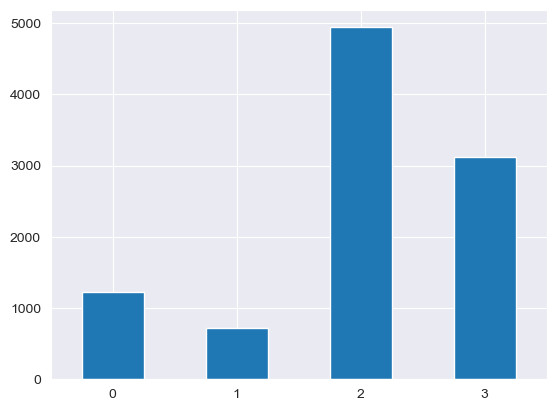

In [64]:
df["event"].value_counts().sort_index().plot.bar(rot=0);

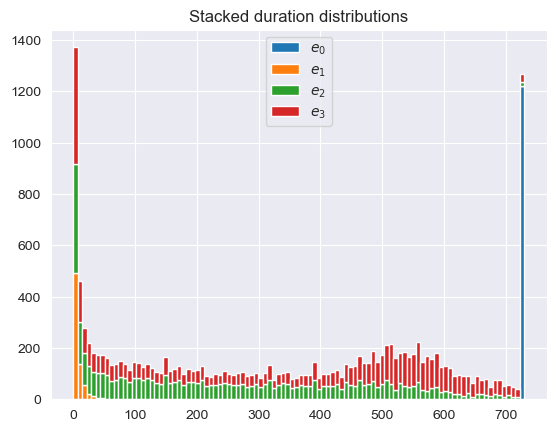

In [84]:
hists = [
    df.loc[event_]["duration"]
    for event_ in [np.logical_not(any_event), event_1, event_2, event_3]
]
labels = [f"$e_{idx}$" for idx in range(4)]
fig, ax = plt.subplots()
ax.hist(hists, bins=100, stacked=True, label=labels);
ax.set(title="Stacked duration distributions")
plt.legend();

In [85]:
df[observed_variables_and_target].to_parquet("factory_dataset.parquet", index=False)

## Target description with simple estimators

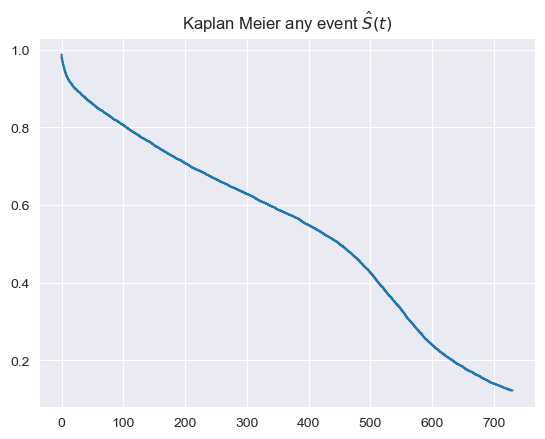

In [269]:
from sksurv.nonparametric import kaplan_meier_estimator

km_x, km_y = kaplan_meier_estimator(any_event, df["duration"])
plt.step(km_x, km_y)
plt.title("Kaplan Meier any event $\hat{S}(t)$");

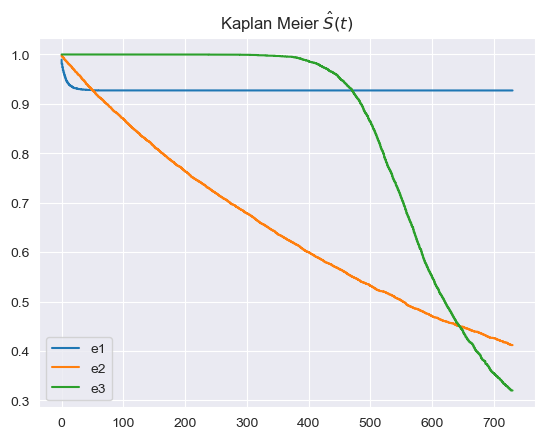

In [261]:
fig, ax = plt.subplots()
for event in [1, 2, 3]:
    km_x_, km_y_ = kaplan_meier_estimator(df["event"] == event, df["duration"])
    ax.step(km_x_, km_y_, label=f"e{event}")
plt.title("Kaplan Meier $\hat{S}(t)$");
plt.legend();

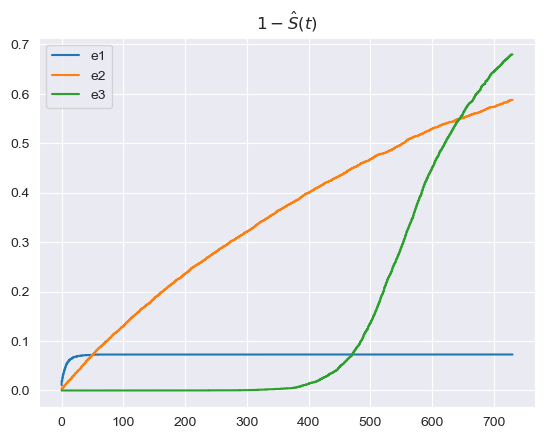

In [262]:
fig, ax = plt.subplots()
for event in [1, 2, 3]:
    km_x_, km_y_ = kaplan_meier_estimator(df["event"] == event, df["duration"])
    ax.step(km_x_, 1 - km_y_, label=f"e{event}")
plt.title("$1-\hat{S}(t)$");
plt.legend();

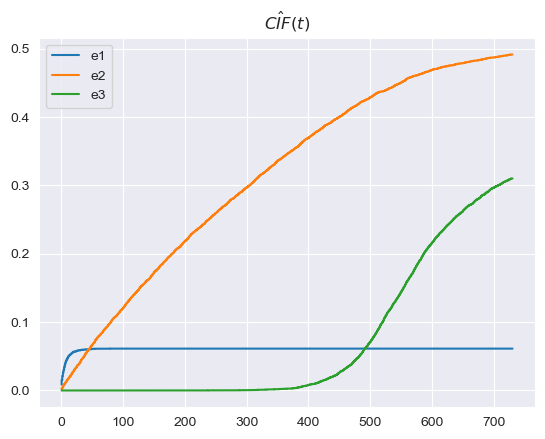

In [263]:
from sksurv.nonparametric import nelson_aalen_estimator

fig, ax = plt.subplots()
for event in [1, 2, 3]:
    na_x_, na_y_ = nelson_aalen_estimator(df["event"] == event, df["duration"])
    h_ = np.diff(na_y_)
    f_ = h_ * km_y[1:]
    cif = f_.cumsum()
    ax.step(na_x_[1:], cif, label=f"e{event}")
plt.title("$\hat{CIF}(t)$");
plt.legend();

/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


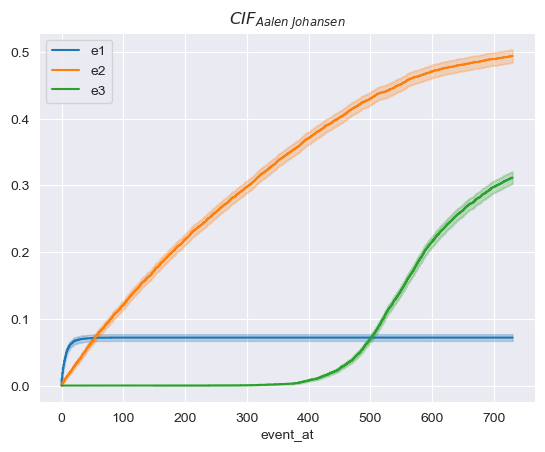

In [150]:
from lifelines import AalenJohansenFitter

for event in [1, 2, 3]:
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(df["duration"], df["event"], event_of_interest=event)
    ajf.plot(label=f"e{event}")
plt.title("$CIF_{Aalen\;Johansen}$");

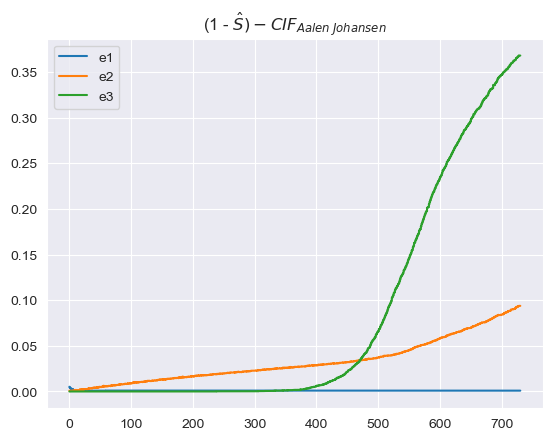

In [268]:
import warnings

fig, ax = plt.subplots()
for event in [1, 2, 3]:
    km_x_, km_y_ = kaplan_meier_estimator(
        df["event"] == event,
        df["duration"],
    )
    
    ajf = AalenJohansenFitter(calculate_variance=True)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ajf.fit(df["duration"], df["event"], event_of_interest=event)
        
    ajf_times = ajf.cumulative_density_.index
    idxs = np.searchsorted(ajf_times, km_x_)
    ajf_cif = ajf.cumulative_density_.iloc[idxs].values.ravel()
    ajf_times = ajf_times[idxs]
    
    cif_diff_ = (1 - km_y_) -  ajf_cif
    ax.step(km_x_, cif_diff_, label=f"e{event}")

plt.title("(1 - $\hat{S}) - CIF_{Aalen\;Johansen}$");
plt.legend();

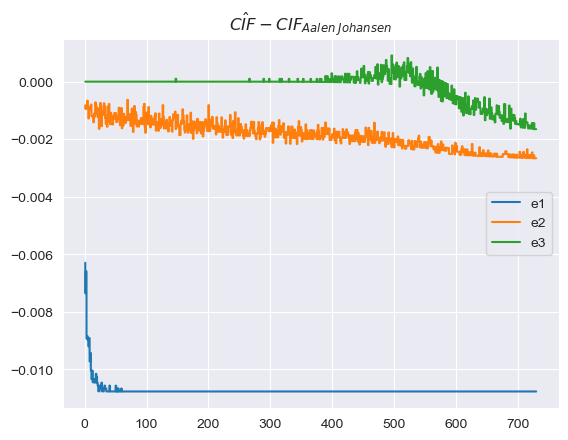

In [270]:
km_x, km_y = kaplan_meier_estimator(any_event, df["duration"])

fig, ax = plt.subplots()
for event in [1, 2, 3]:
    na_x_, na_y_ = nelson_aalen_estimator(df["event"] == event, df["duration"])
    hazards_ = np.diff(na_y_)
    proba_ = hazards_ * km_y[1:]
    cif = proba_.cumsum()
    
    ajf = AalenJohansenFitter(calculate_variance=True)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ajf.fit(df["duration"], df["event"], event_of_interest=event)
        
    ajf_times = ajf.cumulative_density_.index
    idxs = np.searchsorted(ajf_times, km_x_)
    ajf_cif = ajf.cumulative_density_.iloc[idxs].values.ravel()
    ajf_times = ajf_times[idxs]
    
    cif_diff_ = cif -  ajf_cif[1:]
    ax.step(na_x_[1:], cif_diff_, label=f"e{event}")

plt.title("$\hat{CIF} - CIF_{Aalen\;Johansen}$");
plt.legend();

## Sampling targets at fixed conditional X

In [172]:
df.head(1)

,operator_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_lambda,e_2_coeff,e_3_coeff,event,duration
0,1.0,B1,0.89301,Model 5,1.0,0.841782,0.824038,0.814272,1.074038,1.303778,2,45


In [197]:
probas = all_e[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


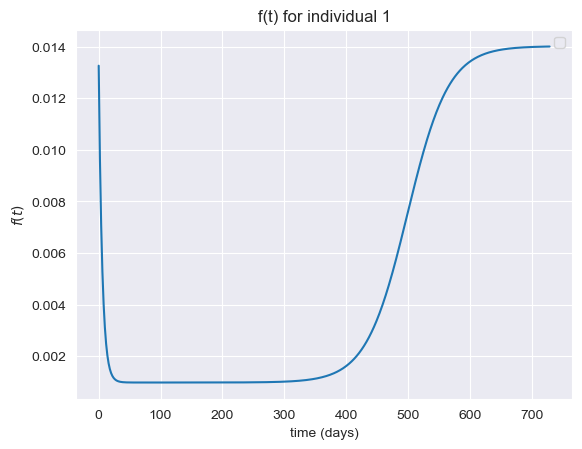

In [200]:
fig, ax = plt.subplots()
ax.plot(probas)
ax.set(
    title="f(t) for individual 1",
    xlabel="time (days)",
    ylabel="$f(t)$"
)
plt.legend();

We select the first individual additive probas.

In [183]:
from tqdm import tqdm

y_fixed = np.empty(
    dtype=[("event", bool), ("duration", np.float64)],
    shape=N,
)
events, durations = [], []
for idx in tqdm(range(N)):
    for t, proba in enumerate(probas):
        trial = bernoulli.rvs(proba, random_state=rng)
        if trial:
            events.append(1)
            durations.append(t)
            break
    else:
        events.append(0)
        durations.append(t)
        
y_fixed["event"] = events
y_fixed["duration"] = durations

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:20<00:00, 71.01it/s]


In [194]:
np.unique(y_fixed["event"], return_counts=True)

(array([False,  True]), array([ 211, 9789]))

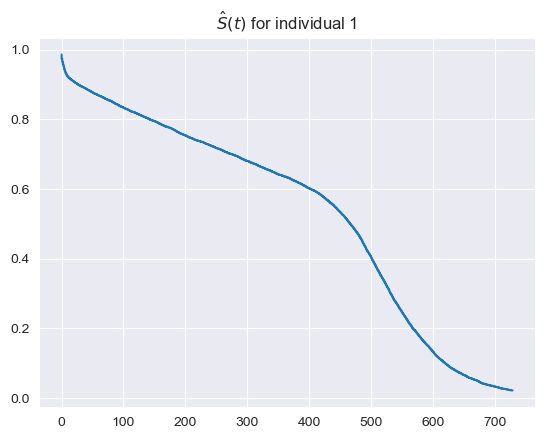

In [253]:
from sksurv.nonparametric import kaplan_meier_estimator

km_x, km_y = kaplan_meier_estimator(y_fixed["event"], y_fixed["duration"])
plt.step(km_x, km_y)
plt.title("$\hat{S}(t)$ for individual 1");

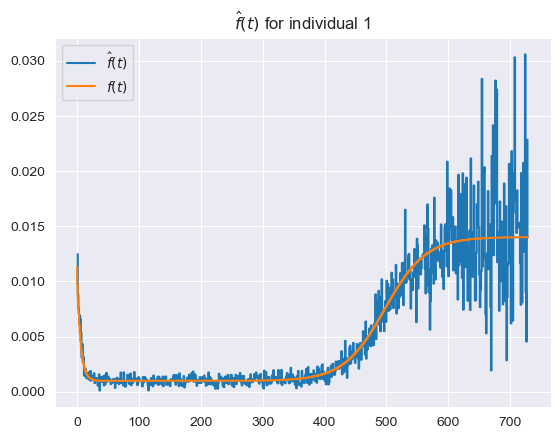

In [258]:
from sksurv.nonparametric import nelson_aalen_estimator

fig, ax = plt.subplots()
na_x, na_y = nelson_aalen_estimator(y_fixed["event"], y_fixed["duration"])
ax.step(na_x[1:], np.diff(na_y), label="$\hat{f}(t)$")
ax.step(na_x, probas[1:], label="$f(t)$")  # probas used to generate our fixed-X data
plt.title("$\hat{f}(t)$ for individual 1")
plt.legend();